In [3]:
%matplotlib inline

import numpy as np
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.optimize as optimize 
import scipy.fftpack as fftpack
import scipy.signal as signal 
import scipy.interpolate
import scipy.integrate as integrate
import types
import scipy.stats as stats
from itertools import tee, izip
# To read spectrograph init file
import csv
# Used for function fitting
import lmfit

pylab.rcParams['figure.figsize'] = (15.0, 3.0)
pylab.rcParams['axes.facecolor'] = 'white'
np.set_printoptions(precision=15)

# Helper functions

In [4]:
def sig_to_fwhm(sig):
    return sig * (2 * np.sqrt(2 * np.log(2)))
def fwhm_to_sig(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

def gauss(x, mu, sigma, amplitude): 
    return amplitude * np.exp( - ((x - mu) ** 2) / (2 * (sigma**2) ))

def gauss_area(l, r, mu, sigma, intensity):
    return intensity * (stats.norm.cdf(r, mu, scale=sigma) - stats.norm.cdf(l, mu, scale=sigma))

def per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
    result = 0.0;
    current = minWl
    i = 0
    while current <= maxWl:
        result += gauss(wl, minWl + (i * period), sigma, amplitude)
        current += period
        i = i + 1
    return result

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return izip(a, b)

# Classes that define simulated instruments.

In [8]:
class Spectrograph:
    def __init__(self, initFilePath, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
        self.order_ids = np.empty(0, dtype=np.int32)
        self.order_peak = np.empty(0)
        self.order_min = np.empty(0)
        self.order_max = np.empty(0)
        self.order_plate_fac = np.empty(0)
        self.order_plate_fac_min = np.empty(0)
        self.order_plate_fac_max = np.empty(0)
        self.order_res = np.empty(0, dtype=np.int32)
        
        with open(initFilePath, 'rb') as initFile:
            reader = csv.DictReader(initFile)
            for row in reader:
                self.order_ids = np.append(self.order_ids, np.int32(row['order']))
                self.order_peak = np.append(self.order_peak, np.float64(row['peak']))
#                 self.order_fsr = np.append(self.order_fsr, np.float64(row['fsr']))
                self.order_min = np.append(self.order_min, np.float64(row['min']))
                self.order_max = np.append(self.order_max, np.float64(row['max']))
                self.order_plate_fac = np.append(self.order_plate_fac, np.float64(row['plate_peak']))
                self.order_plate_fac_min = np.append(self.order_plate_fac_min, np.float64(row['plate_min']))
                self.order_plate_fac_max = np.append(self.order_plate_fac_max, np.float64(row['plate_max']))
                self.order_res = np.append(self.order_res, np.int32(np.floor(np.float64(row['length_peak']))))
                
#         self.order_peak[0] = 410.1
#         self.order_min[0] = 400
#         self.order_max[0] = 420.2
#         self.order_plate_fac_min[0] = 0.001
#         self.order_plate_fac[0] = 0.005
#         self.order_plate_fac_max[0] = 0.01
#         self.order_res[0] = 4000
                
        self.nOrders = len(self.order_ids)
#         self.order_pix_bounds = []
        self.order_pix_means = []
        self.order_fsr = self.order_max - self.order_min
        self.order_fac = self.order_fsr / self.order_res
        for i in range(0, self.nOrders):
#             pix_bounds = self.get_pix_bounds(i)
#             pix_means = ((pix_bounds + np.roll(pix_bounds,-1)) / 2.0)[0:-1]
#             self.order_pix_bounds.append(pix_bounds)
#             self.order_pix_means.append(pix_means)
#             self.order_fsr[i] = np.sum(np.linspace(self.order_plate_fac_min[i], self.order_plate_fac_max[i], self.order_res[i]))
            order_min = self.order_min[i]
            order_max = self.order_max[i]
#             self.order_fac[i] = (order_max - order_min) / self.order_res[i]
            self.order_pix_means.append(np.linspace(order_min + (self.order_fac[i] / 2.0), order_max, self.order_res[i]))
            
        
        self.order_offset = np.int32(self.order_ids[0])
        self.bgrNoiseMu = bgrNoiseMu
        self.bgrNoiseSD = bgrNoiseSD
        self.psf_sigma = fwhm / (2 * np.sqrt(2 * np.log(2))) # sd = fhwm / 2sqrt(2ln2)
        self.precision = precision
        self.blaze = blaze
        
        # Calculate the bootstrap errors of each order
#         startWls = self.minWl + (np.arange(0, self.nOrders) * self.orderSize) 
#         self.bstrap_errs = np.random.normal(0, startWls * fwhm_to_sig(50) / 3e8)
                                            
    # A spectrograph can observe many beams: a beam is a mapping of wavelength (in nm) to intensity
    
    def blaze_order(self, wlSpace, obs, fsr, peak):
        sigma = fsr / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
        return obs * np.exp(-(wlSpace - peak) ** 2 / (2.0 * sigma ** 2)) 
    
    def bstrap_space(self, orders='all'):
        bstrap_space = np.empty((self.nOrders, self.xres,))
        
        if orders == 'all':
            orders = range(0, self.nOrders)
            
        for i in orders:
            startWl = self.minWl + (i * self.orderSize)
            endWl = startWl + self.orderSize
            bstrap_space[i] = np.linspace(startWl, endWl, self.xres, endpoint=False) + self.bstrap_errs[i]
            
        return bstrap_space
    
    # Returns array with pixel boundaries
    def get_pix_bounds(self, order_idx):
        short_wav = self.order_min[order_idx]
        order_len = self.order_res[order_idx]
#         pix_lens = np.linspace(self.order_plate_fac_min[order_idx], self.order_plate_fac_max[order_idx], order_len)
        pix_lens = np.repeat(self.order_plate_fac[order_idx], order_len)
        pixel_boundary = np.zeros(order_len + 1)
        pixel_boundary[0] = short_wav
        for i in range(1, pixel_boundary.size):
            pixel_boundary[i] = pix_lens[i - 1] + pixel_boundary[i - 1]
        return pixel_boundary
    
    def pix_to_wl(self, pix, order_idx):
        return (pix * self.order_fac[order_idx]) + self.order_min[order_idx] + (self.order_fac[order_idx] / 2.0)
    
    def wl_to_pix(self, wl, order_idx):
        return (wl - self.order_min[order_idx] - (self.order_fac[order_idx] / 2.0)) / self.order_fac[order_idx]
        
    def observe(self, beams, orders='all'):
        space = []
        observation = []
#         space = np.empty((self.nOrders, self.xres,))
#         observation = np.empty((self.nOrders, self.xres,))
        
        if orders == 'all':
            orders = self.order_ids
        
        for i in orders:
            idx = i - self.order_offset
            startWl = self.order_min[idx]
            endWl = self.order_max[idx]
            fsr = self.order_fsr[idx]
            blaze_peak = self.order_peak[idx]
            order_obs = np.zeros(self.order_res[idx])
            res = order_obs.size
#             pix_bounds = self.order_pix_bounds[idx]
            pix_means = self.order_pix_means[idx]
            order_fac = self.order_fac[idx]
            
            bgrNoise = np.random.normal(self.bgrNoiseMu, self.bgrNoiseSD, res) # Background noise
            bgrNoise[bgrNoise < 0.0] = 0.0001
            order_obs += bgrNoise

            # Each mapping in a beam becomes a gaussian
            for beam in beams:
                # Approximation for speed: Use only beams in this order
                beam = {k: v for k, v in beam.iteritems() if k > (startWl - (fsr / 10)) and k < (endWl + (fsr / 10))}
                for wl in beam:
                    order_obs = order_obs + gauss(pix_means, wl, self.psf_sigma, beam[wl])

            # Add shot noise
            order_obs += np.random.normal(0.0, np.sqrt(order_obs) * self.precision, res)
            
            # Blaze
            if self.blaze:
                order_obs = self.blaze_order(pix_means, order_obs, fsr, blaze_peak)
            
            order_space = np.linspace(0, res, res)
            space.append(order_space)
            print('pix_sep', np.roll(order_space, -1) - order_space)
            observation.append(order_obs)
        
        return space, observation
    
class LFC:
    def __init__(self, intensity, minWl, maxWl, dWl):
        self.intensity = intensity
        self.minWl = minWl
        self.maxWl = maxWl
        self.span = self.maxWl - self.minWl
        self.dWl = np.float64(dWl)
    def getPeaks(self):
        peaks = np.empty(0)
        current = self.minWl;
        while(current <= self.maxWl):
            peaks = np.append(peaks, current)
            current += self.dWl
        return peaks
    def simulate(self):
        sim = {}
        current = self.minWl
        while current <= self.maxWl:
            sim[current] = self.intensity
            current += self.dWl
        return sim


In [9]:
%%time
# def __init__(self, initFilePath, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
sgraph = Spectrograph('../data/expres_specs.csv', 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(1000000, sgraph.order_min[-1], sgraph.order_max[0] - 1, 1/31.0) # First order has highest wl!

CPU times: user 6.67 ms, sys: 6.67 ms, total: 13.3 ms
Wall time: 12.3 ms


('pix_sep', array([  1.000142653352354e+00,   1.000142653352354e+00,
         1.000142653352354e+00, ...,   1.000142653352668e+00,
         1.000142653351759e+00,  -7.011000000000000e+03]))
CPU times: user 147 ms, sys: 3.33 ms, total: 150 ms
Wall time: 144 ms


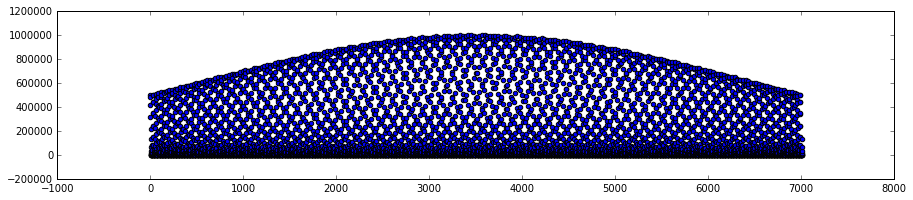

In [13]:
%%time
order = 89
order_idx = order - sgraph.order_offset
orders=[order]
xs, ys = sgraph.observe([lfc.simulate()], orders=orders)
plt.scatter(xs[0], ys[0])
# plt.xlim(2000, 2100)
# plt.xlim(0, 500)
# plt.xlim(3500, 4000)
# print(np.sum(np.linspace(0.001, 0.01, 4000)))

In [14]:
print(sgraph.order_min[order_idx], sgraph.order_max[order_idx])
print(sgraph.order_fac[order_idx])
sgraph.wl_to_pix(1056, order_idx)
sgraph.pix_to_wl(4962, order_idx)

(684.77137842970001, 692.50890812939997)
0.00110362711449


690.24812798536402

# Wavelength calibration

In [15]:
def get_peaks(shift, sgraph, lfc, n, order_idx, mode='wl'):
    if mode == 'wl':
        diff = lfc.dWl
    elif mode == 'pix':
        diff = lfc.dWl / sgraph.order_fac[order_idx]
    else:
        print('Bad mode in peaks')
        return 'error'
    peaks = np.zeros(n)
    current = shift
    for i in range(0, n):
        peaks[i] = current
        current += diff
    return peaks
    
def pred_error(y, pred_y, solution, prediction):
    lse = np.mean(np.abs(y - pred_y))
    error = np.abs(solution - prediction) / solution * 3e8
    return lse, error
    
def guess_min(x, y, lfc, fac):
    sub_y = y[x < (lfc.dWl / fac)]
    sub_x = x[x < (lfc.dWl / fac)]
    idx = np.argmax(sub_y)
    return sub_x[idx], sub_y[idx]

def plot_fit(sgraph, lfc, order_idx, x, y, ss_x, ss_y, y_pred, guess_x, pred_shift_pix, solution):
    fig = plt.figure(1)
#     plt.scatter(ss_x, ss_y, color='magenta', marker='o', facecolors='none')
    plt.scatter(x, y, color='blue', marker='o', facecolors='none')
    plt.plot(ss_x, y_pred, color='red')
    
    lfc_peaks = lfc.getPeaks()
    order_peaks = lfc_peaks[np.logical_and(lfc_peaks > sgraph.order_min[order_idx], lfc_peaks < sgraph.order_max[order_idx])]
    pred_peaks = get_peaks(pred_shift_pix, sgraph, lfc, len(order_peaks), order_idx, mode='pix')
    lfc_peaks = sgraph.wl_to_pix(order_peaks, order_idx)
    for peak in pred_peaks:
        plt.axvline(peak, color='blue')
    for peak in lfc_peaks:
        plt.axvline(peak, color='red')
#     plt.ylim(-100000,800000)
    plt.axvline(guess_x, color='green')
    plt.axvline(solution, color='red')
    plt.axvline(pred_shift_pix, color='turquoise')
#     plt.xlim(sgraph.wl_to_pix(lfc.minWl - 2 * lfc.dWl, order_idx), sgraph.wl_to_pix(lfc.minWl + 8 * lfc.dWl, order_idx))
#     plt.xlim(3800, 4000)
    plt.xlim(0, 200)
#     plt.savefig('../figs/fitted.png')
    return fig

In [16]:
def find_lfc_peaks(sgraph, lfc, order, interpolate, output=True, plot=True, order_model=None):
    lfc_peaks = lfc.getPeaks()
    order_idx = order - sgraph.order_offset
    fac = sgraph.order_fac[order_idx]
    xres = sgraph.order_res[order_idx]
    startWl = sgraph.order_min[order_idx]
    endWl = sgraph.order_max[order_idx]
    
    lfc_beam = lfc.simulate()
    xs, ys = sgraph.observe([lfc_beam], orders=[order])
    x = xs[0]
    y = ys[0]
    
    if interpolate:
        # Do a cubic interpolation of x and y 
        spl = scipy.interpolate.UnivariateSpline(x, y, k=3)
        # ss stands for supersampled
        ss_x = np.linspace(0, xres, xres * 5, dtype=np.float64)
        ss_y = spl(ss_x)
    else:
        ss_x = x
        ss_y = y
        
    ss_y[ss_y <= 0.0] = 1e-15
    
    if order_model == None:
        def order_model(wl, minWl):
            maxWl = minWl + sgraph.order_res[order_idx] 
            result = per_gauss(wl, sgraph.psf_sigma / fac, minWl, maxWl, lfc.dWl / fac, np.max(ss_y))
            if sgraph.blaze:
                sigma = xres / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
                result = result * np.exp(-(wl - (xres / 2)) ** 2 / (2.0 * sigma ** 2)) 
            return result
    
    order_min = sgraph.order_min[order_idx]
    order_beam = {k: v for k, v in lfc_beam.iteritems() if k >= order_min}
#     print('beam', sgraph.wl_to_pix(sorted(order_beam.keys()), order_idx))
#     print('beam', sorted(order_beam.keys())[0:10])
    solution_wl = min(order_beam)
    solution_pix = sgraph.wl_to_pix(solution_wl, order_idx)
    if output:
        print('Solution is: {}pix or {}nm'.format(solution_pix, solution_wl))

    # Fit on interpolated data
    guess_x, guess_y = guess_min(ss_x, ss_y, lfc, fac)
    if output:
        print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), sgraph.pix_to_wl(guess_x, order_idx)))
    
    # Use lmfit for fitting
    gmod = lmfit.Model(order_model)
    result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='lbfgsb', weights=1/np.sqrt(ss_y),
                      options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':1.0, 'disp':True, 
                               'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
#     result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='leastsq', weights=1/np.sqrt(ss_y),
#                       options={'disp': True, 'xtol': 1e-20, 'ftol': 1e-20, 'maxiter':20000000, 'maxfev':200000})
    pred_shift_pix = result.params['minWl'].value
    y_pred = result.best_fit
    nfev = result.nfev
    pred_shift_wl = sgraph.pix_to_wl(pred_shift_pix, order_idx)
    
    if output:
        print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift_pix]), pred_shift_wl))
        print('Number of calls: {}'.format(nfev))
    
    lse, error = pred_error(ss_y, y_pred, solution_wl, pred_shift_wl)
    if output:
        print('Least squares error is {}'.format(lse))
        print('Error is: {}m/s'.format(error))
    
    fig = None
    if plot:
        fig = plot_fit(sgraph, lfc, order_idx, x, y, ss_x, ss_y, y_pred, guess_x, pred_shift_pix, solution_pix)
    
    return ss_x, ss_y, pred_shift_pix, lse, error, fig

In [17]:
rand = np.random.random(1)[0]
SNR = 1000
# def __init__(self, initFilePath, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
sgraph = Spectrograph('../data/expres_specs.csv', 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(SNR ** 2, sgraph.order_min[-1] + rand, sgraph.order_max[0] - 1 + rand, 1 / 31.0) # First order has highest wl!

('pix_sep', array([  1.000142653352354e+00,   1.000142653352354e+00,
         1.000142653352354e+00, ...,   1.000142653352668e+00,
         1.000142653351759e+00,  -7.011000000000000e+03]))
Solution is: 5.06261944659pix or 684.777517487nm
Initial guess for shift is: [ 5.000713266761769]pix or 684.777449166nm
 - Adding parameter "minWl"
Predicted shift is: [ 5.312246182680245]pix or 684.777792982nm
Number of calls: 25
Least squares error is 6474.05636191
Error is: 120.693872427m/s
CPU times: user 3.59 s, sys: 20 ms, total: 3.61 s
Wall time: 3.61 s


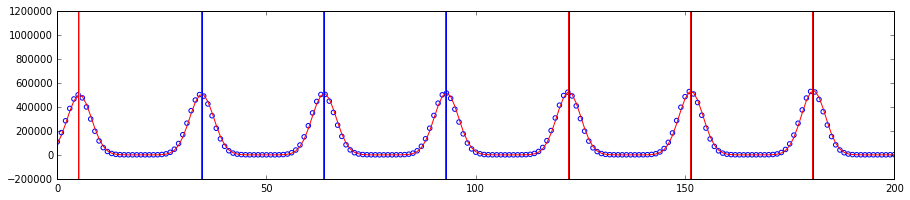

In [19]:
%%time
interpolate = False
order = 89
ss_x, ss_y, _, _, _, fig = find_lfc_peaks(sgraph, lfc, order, interpolate)
fig.show()

(684.77137842970001, 692.50890812939997)
7011


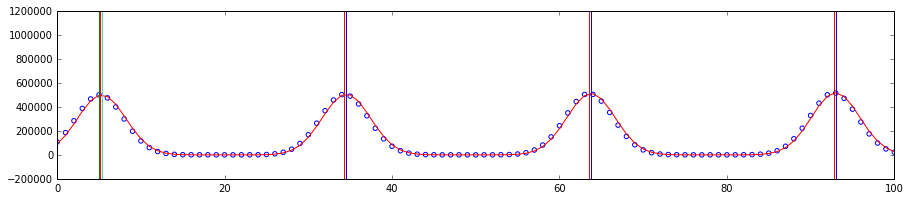

In [20]:
# fig.xlim(0, 300)
order_idx = order - sgraph.order_offset
ax1 = fig.axes[0]
xres = sgraph.order_res[order_idx]
print(sgraph.order_min[order_idx], sgraph.order_max[order_idx])
print(xres)
# ax1.set_xlim(39, 400)
# ax1.set_xlim(6000, 6100)
# ax1.set_xlim(4900, 5000)
ax1.set_xlim(0, 100)
# ax1.set_xlim(xres-50, xres)
# ax1.set_xlim(0, xres)
fig

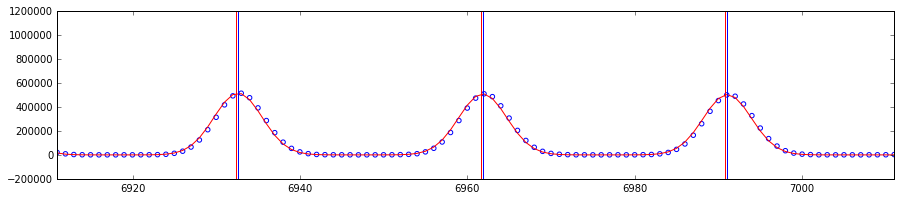

In [21]:
# fig.xlim(0, 300)
order_idx = order - sgraph.order_offset
ax1 = fig.axes[0]
xres = sgraph.order_res[order_idx]
ax1.set_xlim(xres-100, xres)
fig

In [ ]:
%%time
# Make a plot of error to SNR
def sensitivity(sgraph, lfc, attr, nReps, rang, tol=6, **kwargs):
    x = np.zeros(len(rang))
    y = np.zeros((len(rang), nReps))
    print('Running %d times for each value in %s' % (nReps, rang))
    for i, val in enumerate(rang):
        print('Run %d with %f %s' % (i, val, attr))
        if hasattr(lfc, attr):
            setattr(lfc, attr, val)
        elif hasattr(sgraph, attr):
            setattr(sgraph, attr, val)
        else:
            print('Error, bad attribute')
            return
        x[i] = val
        for j in range(0, nReps):
            err = tol
            while err >= tol:
                _, _, _, _, err = find_lfc_peaks(sgraph, lfc, True, **kwargs)
            y[i][j] = err
    return x,y

# SNR sensitivity plot

In [ ]:
%%time
rand = np.random.random(1)[0]
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
lfc = LFC(1000000, 400 + rand, 430 + rand, 0.03)

# rang = [10000, 40000, 90000, 160000, 250000, 360000]
# rang = [490000, 640000, 810000, 1000000]
rang = [200 ** 2, 400 ** 2, 600 ** 2, 800 ** 2, 1000 ** 2]
print(rang)
snr_plot_axis, snr_plot_data = sensitivity(sgraph, lfc, 'intensity', 20, rang, output=True, plot=False)
plt.boxplot(np.transpose(snr_plot_data), labels=np.char.mod('%f', np.sqrt(snr_plot_axis)))
plt.show()
%store snr_plot_axis
%store snr_plot_data

In [ ]:
plt.figure(1, figsize=(10,3))
plt.boxplot(np.transpose(snr_plot_data), labels=np.char.mod('%.1f', np.sqrt(snr_plot_axis)))
plt.ylabel('Error in m/s')
plt.xlabel('SNR')
ax = plt.subplot(111)
ax.set_yscale('log')
plt.ylim(1e-4, 1e1)
plt.axhline(0.1, color='black', linestyle='dashed')
plt.figtext(0.6, 0.35, 'Goal precision', size='xx-large')
plt.savefig('../figs/snrverr.png')

# PSF stability sensitivity plot

In [ ]:
%%time
rand = np.random.random(1)[0]
# def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(1000000, 400 + rand, 430 + rand, 0.03)


rang = [(0.0075 + (0.0025 / 10)) / (2 * np.sqrt(2 * np.log(2))), 
        (0.0075 + (0.0025 / 25)) / (2 * np.sqrt(2 * np.log(2))),
        (0.0075 + (0.0025 / 50)) / (2 * np.sqrt(2 * np.log(2))),
        (0.0075 + (0.0025 / 100)) / (2 * np.sqrt(2 * np.log(2)))]
print(rang)
model_sigma = sgraph.psf_sigma * sgraph.fac
def model(wl, minWl):
    lfc_peaks = lfc.getPeaks()
    maxWl = minWl + (len(lfc_peaks) * lfc.dWl * sgraph.fac)
    result = per_gauss(wl, model_sigma, minWl, maxWl, lfc.dWl * sgraph.fac, lfc.intensity)
    if sgraph.blaze:
        sigma = sgraph.xres / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
        result = result * np.exp(-(wl - (sgraph.xres / 2)) ** 2 / (2.0 * sigma ** 2)) 
    return result

psf_plot_axis, psf_plot_data = sensitivity(sgraph, lfc, 'psf_sigma', 20, rang, tol=10, plot=True, output=True, order_model=model)
plt.boxplot(np.transpose(psf_plot_data), labels=np.char.mod('%e', np.arange(2.7, 3.31, 1/10.0)))
plt.show()
%store psf_plot_axis
%store psf_plot_data

In [ ]:
plt.figure(1, figsize=(10,3))
plt.boxplot(np.transpose(psf_plot_data), labels=np.char.mod('%.2f', np.asarray([3.1, 3.04, 3.02, 3.01])))
plt.xlabel('Full width at half maximum of simulated PSF')
plt.ylabel('Error in m/s')
plt.savefig('../figs/stabverr.png')
# Add some more points, in range 1/10th pixel. Maybe (0.5, 0.1, 0.01), something like that

# Correlation of residuals with shift difference

In [ ]:
%%time
rand = np.random.random(1)[0]
SNR = 1000
n = 100
tol = 100.0
lses = np.zeros(n)
errors = np.zeros(n)
for i in range(0, n):
    print('Run %d:' % (i))
    # def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
    sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
    # def __init__(self, intensity, minWl, maxWl, dWl):
    lfc = LFC(SNR ** 2, 400 + rand, 430 + rand, 1/31.0)
    interpolate = True
    error = tol + 1
    while error >= tol:
        _, _, _, lse, error = find_lfc_peaks(sgraph, lfc, interpolate, output=True, plot=False)
    lses[i] = lse
    errors[i] = error
%store lses
%store errors
plt.scatter(errors, lses)

In [ ]:
def fit(x, m, b):
    return m*x+b
gmod = lmfit.Model(fit)
result = gmod.fit(lses, x=errors, m=1, b=0, method='leastsq', options={})
print(result.fit_report())
print(result.ci_report())
preds = result.best_fit
plt.scatter(errors, lses)
plt.plot(errors, preds)
m = result.params['m'].value
b = result.params['b'].value
print('m: %f, b: %f' % (m, b))


In [ ]:
plt.hist(lses)

# Assigning wavelengths to pixels

In [ ]:
rand = np.random.random(1)[0]
interpolate = True
SNR = 1000
# def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(SNR ** 2, 400 + rand, 430 + rand, 1/31.0)
x, y, pred_shift, _, _ = find_lfc_peaks(sgraph, lfc, interpolate)
pred_shift_wl = sgraph.pix_to_wl(pred_shift)
peaks = get_peaks(pred_shift, sgraph, lfc, len(lfc.getPeaks()), mode='pix')
bstrap_space = sgraph.bstrap_space(orders=[0])

plt.scatter(x, y)
for peak in peaks:
    plt.axvline(peak)
plt.show()

# Notes
**For future**:
- Make a table of effect of increasing the lfc intensity
- Create plot of jitter to error
- Resolution = wl of order / (wl to pix ratio) -> 400 / 0.025
- 80 orders [pix, intens, order]
- Further away orders are distorted
- Should use adjacent order
- Generate plots of SNR to error in cm/s
    - Moving Sigma from 2 to 4, R from 50,000 to 20,0000
- Paper submission to PASP

**Open questions**:
- Spectrograph error distribution: what is a good mean and a mean sdev?
- Doing least squares: should I weight according to error? For example, know error increases with intensity


**Todays notes**:
Stop plot at SNR 500 (intensity 250,000)


**Ask tyler for specs of EXPRESS**
IOP paper guidelines

In [ ]:
plt.boxplot(np.transpose(y), labels=x)
plt.ylim(0,3)
plt.show()

In [ ]:
print(y)

# Using energy instead of SNR directly

In [ ]:
hc = 1.9864458e-25
integ = integrate.quad(lambda wl: gauss(wl, 0, 4, 1), -np.inf, np.inf)
# x = np.linspace(-20, 20, 1000)
# y = gauss(x, 0, 4, 1)
# plt.hist(y, 100)
# plt.plot(x,y)
print(integ[0])
# k = laser_E / photon_energy
laser_e = 12
wl = 400e-9
k = (laser_e / (hc / wl)) / integ[0]
k

# Failed code to use multiple orders in fitting: impossible!

In [ ]:
def find_lfc_peaks_mult_orders(sgraph, lfc, orderId):
    lfc_peaks = lfc.getPeaks()
    
    print('Solution is: {}pix or {}nm'.format(sgraph.wl_to_pix(lfc.minWl), lfc.minWl))

    space, obs = sgraph.observe([lfc.simulate()])
    
    bottom = False
    top = False
    mid = False
    orders = []
    spaces = []
    # Select relevant orders
    if orderId == 0: # If first order in spectrum
        bottom = True
        orders.append(obs[0])
        spaces.append(space[0])
        if len(obs) > 1:
            orders.append(obs[1])
            spaces.append(space[1])
    elif orderId == len(obs) - 1: # else if last
        top = True
        orders.append(obs[-1])
        spaces.append(space[-1])
        if len(obs) > 1:
            orders.append(obs[-2])
            spaces.append(space[-2])
    else: # else middle order
        mid = True
        orders.append(obs[orderId - 1])
        spaces.append(space[orderId - 1])
        orders.append(obs[orderId])
        spaces.append(space[orderId])
        orders.append(obs[orderId + 1])
        spaces.append(space[orderId + 1])
        
    ss_xres = 5 * sgraph.xres
    ss_xs = np.empty((len(orders), ss_xres))
    ss_ys = np.empty((len(orders), ss_xres))
    prev_range = None
    # Interpolate selected orders
    for i in range(0, len(orders)):
        x = spaces[i]
        y = orders[i]
        
        spl = interpolate.UnivariateSpline(x, y, k=3)
        # This is the tricky part. I need the 'distance' between orders, so that I can
        # align them in pixel space correctly. For now, I am assuming that they are adjacent
#         ss_x = np.linspace(order_range[0], order_range[1], ss_xres, dtype=np.float64)
        ss_x = np.linspace(x[0], x[-1], ss_xres)
        ss_y = spl(ss_x)
        ss_y[ss_y <= 0.0] = 1e-15
        
        ss_xs[i] = ss_x
        ss_ys[i] = ss_y
        
    # Paste orders together
    all_ss_x = np.concatenate(ss_xs)
    all_ss_y = np.concatenate(ss_ys)
    
    # Fit on interpolated data
    def per_gauss_fit(wl, shift):
        # per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
        return per_gauss(wl, sgraph.sigma * sgraph.fac, all_ss_x[0] + shift, all_ss_x[-1] + shift, 
                         lfc.dWl * sgraph.fac, lfc.intensity)
    
    def err_func(shift):
        err = 0.0
        # Fit the same per_gauss on each order
        for i in range(0, len(ss_xs)):
            err += np.mean(np.abs(per_gauss_fit(ss_xs[i], shift) - ss_ys[i]))
        return err
        
    guess_x, guess_y = guess_min(ss_xs[0], ss_ys[0])
    print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), sgraph.pix_to_wl(guess_x)))
    
    gmod = lmfit.Model(per_gauss_fit)
    # Should weight as well!!
    result = gmod.fit(all_ss_y, wl=all_ss_x, shift=guess_x, method='lbfgsb', 
                      options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':1.0, 'disp':True, 
                               'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
    pred_shift = result.params['shift'].value
    all_y_pred = result.best_fit
    nfev = result.nfev
    
    pred_shift_wl = sgraph.pix_to_wl(pred_shift)
    
    print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
    print('Number of calls: {}'.format(nfev))
  
    lse, error = pred_error(all_ss_y, all_y_pred, lfc.minWl, pred_shift_wl)
    print('Least squares error is {}'.format(lse))
    print('Error is: {}m/s'.format(error))
    
    plt.scatter(all_ss_x, all_ss_y, color='blue')
    plt.plot(all_ss_x, all_y_pred, color='red')
    plt.axvline(guess_x, color='turquoise')
#     plt.xlim(sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl + 12 * lfc.dWl))
    plt.xlim(7000, 7150)
    fig = plt.show()
    
    return error